In [10]:
## Parameters
import math
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
dataset = 'banking77' # dataset: banking77, clinc, reddit, stackexchange, mtop_domain, clinc_domain, few_event, go_emotion, 
embedder = 'NV-Embed-v2' # 'NV-Embed-v2', 'gte-Qwen2-1.5B-instruct', 'stella-en-400M-v5', 'OpenAI'
seed = 42


llm = 'gpt-4o-mini' # 'gpt-4o-mini', 'gpt-4o', "Meta-Llama-3.1-8B-Instruct-Turbo", 'claude-3-haiku-20240307'
llm_folder_name_map = {
    'gpt-4o-mini': 'gpt4omini',
    'gpt-4o': 'gpt4o',
    "Meta-Llama-3.1-8B-Instruct-Turbo": 'llama31',
    'claude-3-haiku-20240307': 'claude'}
    
# llm_folder_name = 'gpt4o' # gpt4o, gpt4omini, llama31, claude 
llm_folder_name = llm_folder_name_map[llm]

data_path = f'./../scripts_{llm_folder_name}/output/nuc/{dataset}/{dataset}_pseudo_labeled_{llm}.jsonl'

print('Data path:', data_path)


Data path: ./../scripts_gpt4omini/output/nuc/banking77/banking77_pseudo_labeled_gpt-4o-mini.jsonl


In [11]:
## Load Data 

# Load Pseudo-labeled Data
data = pd.read_json(data_path, lines=True)

# Obtain all unique labels
labels = data['ground_truth'].unique()
print('Number of unique labels:', len(labels))
print('Number of samples:', len(data))

# Rename column 'input' to 'text'
data = data.rename(columns={'input': 'text'})

# Encode the labels
from sklearn.preprocessing import LabelEncoder
# Combine unique values from both columns to create a consistent mapping
unique_labels = pd.concat([data['ground_truth'], data['prediction']]).unique()

# Fit the LabelEncoder on the combined unique labels
label_encoder = LabelEncoder()
label_encoder.fit(unique_labels)

# Transform the columns using the same encoder
data['encoded_ground_truth'] = label_encoder.transform(data['ground_truth'])
data['encoded_prediction'] = label_encoder.transform(data['prediction'])

# Display the first few rows of the data
data

Number of unique labels: 77
Number of samples: 10003


,text,ground_truth,prediction,confidence,encoded_ground_truth,encoded_prediction
0,My physical card is not working,card not working,card not working,0.95,17,17
1,Can you unblock my account? I entered the PIN...,pin blocked,pin blocked,0.90,58,58
2,I need to know what is going on. I'm attemptin...,failed transfer,failed transfer,0.85,38,38
3,I am unable to prove my identity,unable to verify identity,unable to verify identity,0.92,79,79
4,I am still waiting for my card.,card arrival,card arrival,0.88,14,14
...,...,...,...,...,...,...
9998,What is the present state of the exchange rate?,exchange rate,exchange rate,0.82,35,35
9999,maximum how many days get the courier?,card arrival,card delivery estimate,0.76,14,15
10000,How would I top up with a cheque?,top up by cash or cheque,top up by cash or cheque,0.85,68,68
10001,Where can I change my PIN?,change pin,change pin,0.90,24,24


In [12]:
## Load Embeddings into the original data
import torch
import pandas as pd


# load original data
data_path = f'../data/datasets/{dataset}/large.jsonl'
data_original = pd.read_json(data_path, lines=True)
# rename column 'input' to 'text'
data_original = data_original.rename(columns={'input': 'text'})

# only keep top 25k data
data_original = data_original[:25000]

print('Number of samples:', len(data_original))


# Loading embeddings
embedding_path = f'../data/embeddings/{dataset}/{embedder}.pt'

data_embedding = torch.load(embedding_path)
# as pandas dataframe
data_embedding = pd.DataFrame(data_embedding.numpy())
print(data_embedding.shape)


# check if the embeddings shape is the same with with the original data
assert data_embedding.shape[0] == len(data_original)

# add the embeddings to the original data
data_original['embedding'] = data_embedding.values.tolist()

data_original

Number of samples: 10003
(10003, 4096)


,task,text,label,embedding
0,banking77,My physical card is not working,card not working,"[0.007431757170706987, 0.023320766165852547, -..."
1,banking77,Can you unblock my account? I entered the PIN...,pin blocked,"[0.020142048597335815, -0.003620085073634982, ..."
2,banking77,I need to know what is going on. I'm attemptin...,failed transfer,"[-0.0015997248701751232, -0.000463426928035914..."
3,banking77,I am unable to prove my identity,unable to verify identity,"[0.005096125416457653, 0.013860966078937054, 0..."
4,banking77,I am still waiting for my card.,card arrival,"[-0.022129448130726814, 0.024606743827462196, ..."
...,...,...,...,...
9998,banking77,What is the present state of the exchange rate?,exchange rate,"[-0.01419543195515871, -0.00548851303756237, 0..."
9999,banking77,maximum how many days get the courier?,card arrival,"[0.012195377610623837, -0.015386601909995079, ..."
10000,banking77,How would I top up with a cheque?,top up by cash or cheque,"[-0.0018875328823924065, 0.012713853269815445,..."
10001,banking77,Where can I change my PIN?,change pin,"[0.010482830926775932, 0.003605414414778352, -..."


In [13]:
# Merge the dataframes 
data_merge = data.merge(data_original, on=['text'], how='inner')

# Only keep the necessary columns: text, ground_truth, prediction, confidence, encoded_ground_truth, encoded_prediction, and embeddings
data_merge = data_merge[['text', 'ground_truth', 'prediction', 'confidence', 'encoded_ground_truth', 'encoded_prediction', 'embedding']]
data_merge = data_merge.drop_duplicates(subset=['text', 'ground_truth', 'prediction', 'confidence', 'encoded_ground_truth', 'encoded_prediction'])

# Obtain all unique labels
labels = data_merge['ground_truth'].unique()
print('Number of unique labels:', len(labels))
print('Number of samples:', len(data_merge))

# Display the first few rows of the data
data = data_merge
data

Number of unique labels: 77
Number of samples: 10002


,text,ground_truth,prediction,confidence,encoded_ground_truth,encoded_prediction,embedding
0,My physical card is not working,card not working,card not working,0.95,17,17,"[0.007431757170706987, 0.023320766165852547, -..."
1,Can you unblock my account? I entered the PIN...,pin blocked,pin blocked,0.90,58,58,"[0.020142048597335815, -0.003620085073634982, ..."
2,I need to know what is going on. I'm attemptin...,failed transfer,failed transfer,0.85,38,38,"[-0.0015997248701751232, -0.000463426928035914..."
3,I am unable to prove my identity,unable to verify identity,unable to verify identity,0.92,79,79,"[0.005096125416457653, 0.013860966078937054, 0..."
4,I am still waiting for my card.,card arrival,card arrival,0.88,14,14,"[-0.022129448130726814, 0.024606743827462196, ..."
...,...,...,...,...,...,...,...
10006,What is the present state of the exchange rate?,exchange rate,exchange rate,0.82,35,35,"[-0.01419543195515871, -0.00548851303756237, 0..."
10007,maximum how many days get the courier?,card arrival,card delivery estimate,0.76,14,15,"[0.012195377610623837, -0.015386601909995079, ..."
10008,How would I top up with a cheque?,top up by cash or cheque,top up by cash or cheque,0.85,68,68,"[-0.0018875328823924065, 0.012713853269815445,..."
10009,Where can I change my PIN?,change pin,change pin,0.90,24,24,"[0.010482830926775932, 0.003605414414778352, -..."


##################################################
Number of Unlabeled Data: 1
Train, Test Split Size: 1 1001


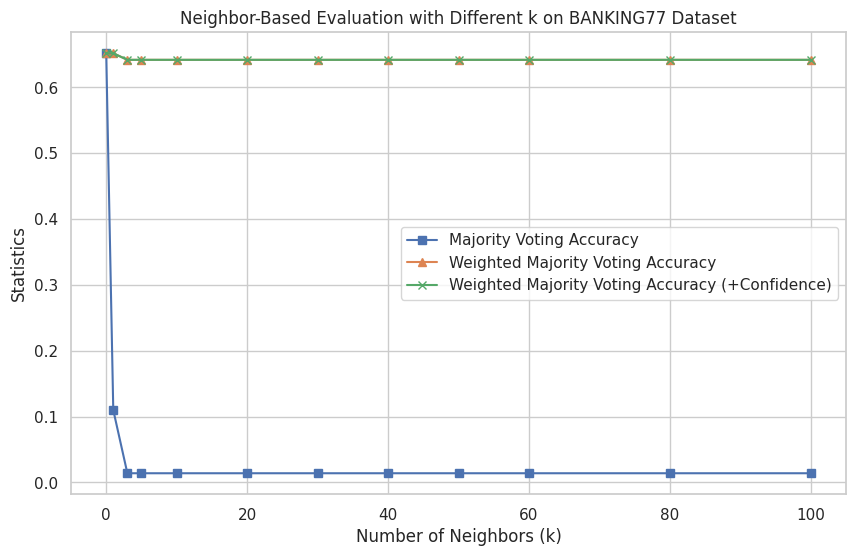

Dataset Name: banking77
Number of Unlabeld Data: 1
Best k: 0 Best Result: 65.2
##################################################
Number of Unlabeled Data: 500
Train, Test Split Size: 500 1001


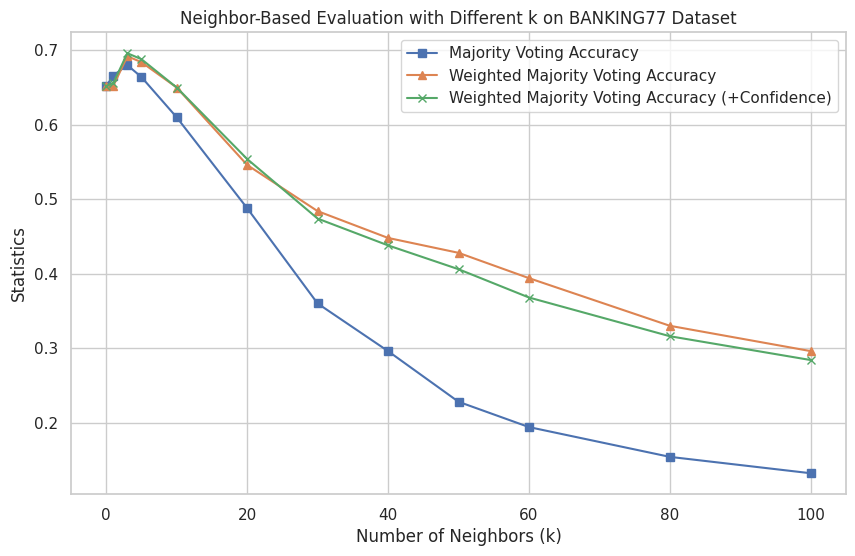

Dataset Name: banking77
Number of Unlabeld Data: 500
Best k: 3 Best Result: 69.6
##################################################
Number of Unlabeled Data: 1000
Train, Test Split Size: 1000 1001


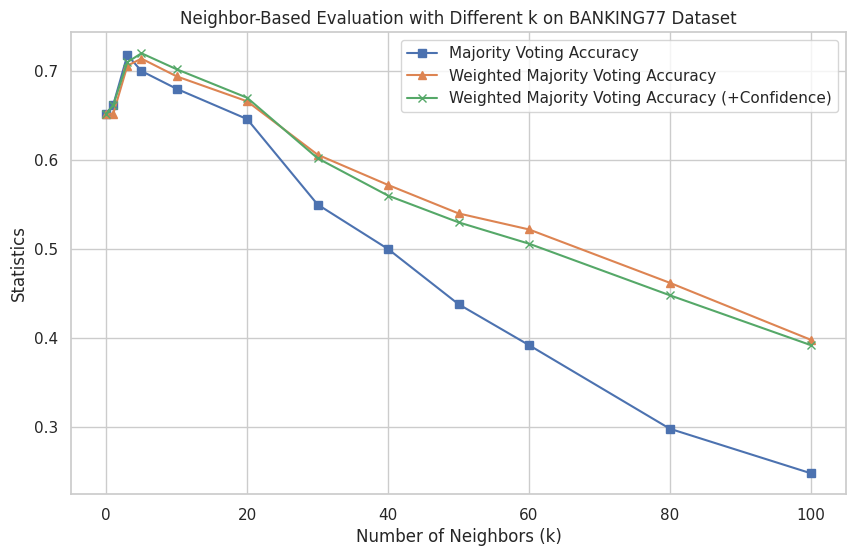

Dataset Name: banking77
Number of Unlabeld Data: 1000
Best k: 5 Best Result: 72.0
##################################################
Number of Unlabeled Data: 2500
Train, Test Split Size: 2500 1001


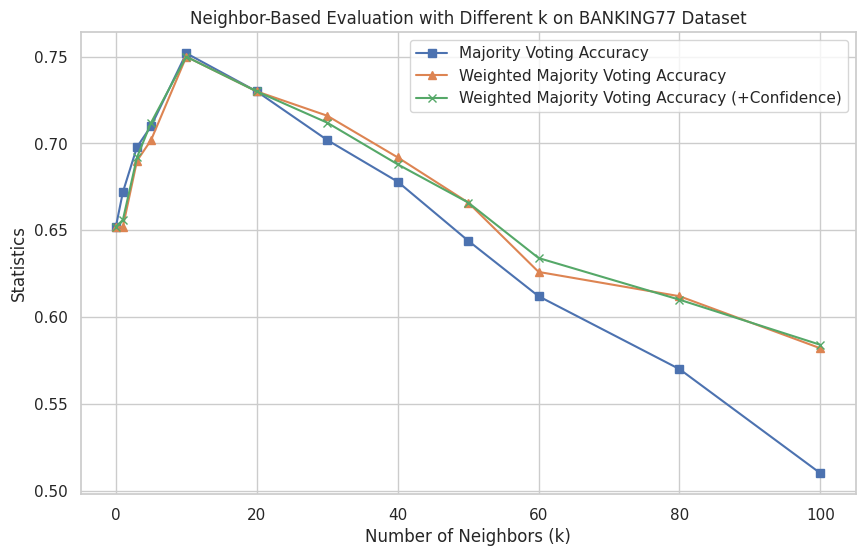

Dataset Name: banking77
Number of Unlabeld Data: 2500
Best k: 10 Best Result: 75.2
##################################################
Number of Unlabeled Data: 5000
Train, Test Split Size: 5000 1001


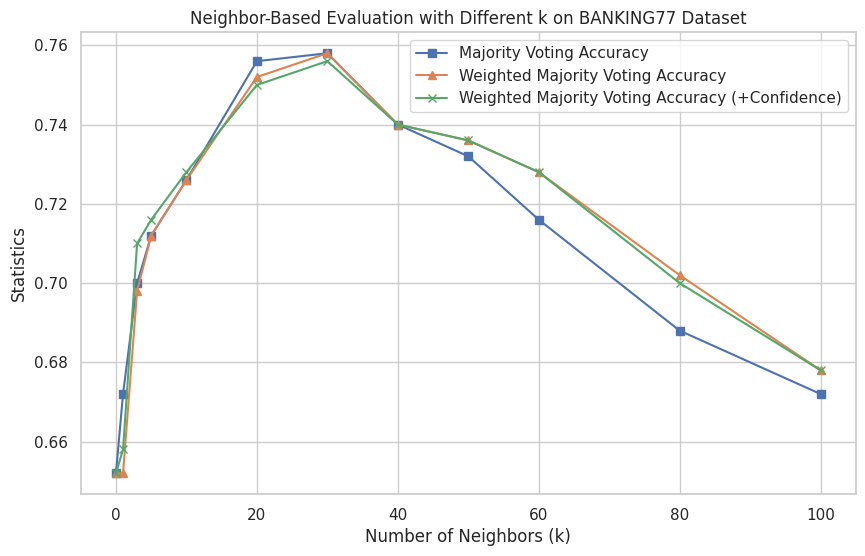

Dataset Name: banking77
Number of Unlabeld Data: 5000
Best k: 30 Best Result: 75.8
##################################################
Number of Unlabeled Data: 10000
Train, Test Split Size: 10000 1001


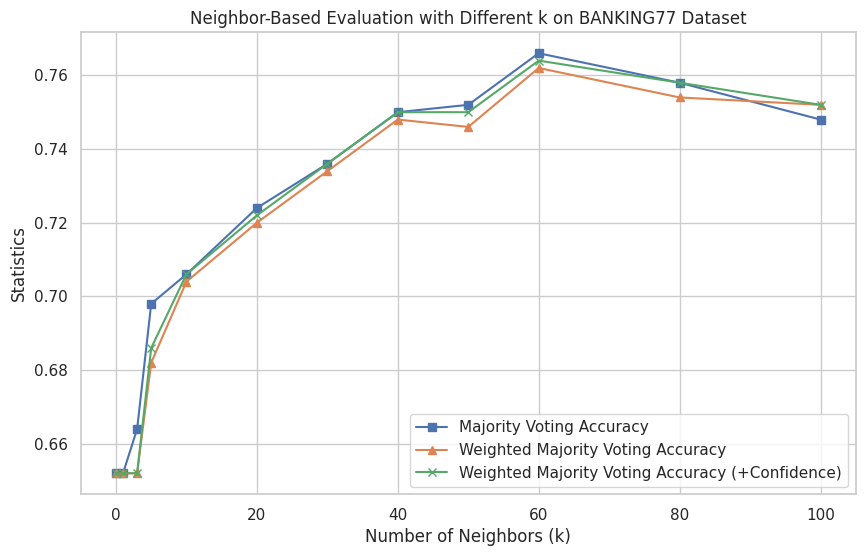

Dataset Name: banking77
Number of Unlabeld Data: 10000
Best k: 60 Best Result: 76.6
#### Summary ####
Best Results: [65.2, 69.6, 72.0, 75.2, 75.8, 76.6]
Best k: [0, 3, 5, 10, 30, 60]


In [14]:
## Retrieve neighbors and Aggregate neighbors’ prediction with different number of unlabeled data

import numpy as np
import pandas as pd
import faiss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

num_unlabeled_data_list = [1, 500, 1000, 2500, 5000, 10000]

best_results = []
best_ks = []

for num_unlabeled_data in num_unlabeled_data_list:
    print('#' * 50)
    print('Number of Unlabeled Data:', num_unlabeled_data)
    # Data Setting: train, test = K, 10%
    # num_unlabeled_data= 20000
    data_train = data[:num_unlabeled_data]
    data_test = data[int(0.9 * len(data)):]
    print('Train, Test Split Size:', len(data_train), len(data_test))

    # randomly select a subset of test data for evaluation
    test_subset_size = 500
    data_test_subset = data_test.sample(n=test_subset_size, random_state=seed).reset_index(drop=True)
    # print('Test Subset Size:', len(data_test_subset))

    # Read Test Embeddings
    embeddings_test = data_test_subset['embedding'].apply(np.array)
    embeddings_test = np.stack(embeddings_test).astype('float32')
    # print('Test Embeddings shape:', embeddings_test.shape)
    # Read Training Embeddings
    embeddings_train = data_train['embedding'].apply(np.array)
    embeddings_train = np.stack(embeddings_train).astype('float32')
    # print('Training Embeddings shape:', embeddings_train.shape)

    ## Mine Neighbors
    # Configurations
    topk = 500
    k_list = [0, 1, 3, 5, 10, 20, 30, 40, 50, 60, 80, 100]

    # FAISS Index
    dim = embeddings_train.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings_train)
    distances, indices = index.search(embeddings_test, topk)
    # print('Indices shape:', indices.shape)

    # Initialize statistics
    majority_voting_accuracies = []
    weighted_majority_accuracies = []
    weighted_majority_accuracies_conf = []

    # Loop through different k values
    for k in k_list:
        majority_accuracies = []
        weighted_accuracies = []
        weighted_accuracies_conf = []

        for i in range(len(data_test_subset)):
            # Retrieve neighbors
            # neighbor_indices = indices[i, 1:1 + k]
            neighbor_indices = indices[i, :k]
            neighbor_labels = data_train.iloc[neighbor_indices]['encoded_prediction'].values
            query_label = data_test_subset.iloc[i]['encoded_ground_truth']
            # neighbor_distances = distances[i, 1:1 + k]
            neighbor_distances = distances[i, :k]
            neighbor_confidences = data_train.iloc[neighbor_indices]['confidence'].values

            # add the query data itself to the neighbors
            neighbor_labels = np.append(neighbor_labels, data_test_subset.iloc[i]['encoded_prediction'])
            neighbor_distances = np.append(neighbor_distances, 1.0)
            neighbor_confidences = np.append(neighbor_confidences, data_test_subset.iloc[i]['confidence'])
            

            # Majority Voting Accuracy
            majority_label = pd.Series(neighbor_labels).mode().iloc[0]
            majority_accuracies.append(int(majority_label == query_label))

            # Weighted Majority Voting (based on distance)
            # weights = 1 / (neighbor_distances + 1e-8)  # Avoid division by zero
            weights = neighbor_distances  # Use distance/similarity as weight
            weighted_votes = np.bincount(neighbor_labels, weights=weights)  # The function np.bincount() counts occurrences of each label in the neighbor_labels array, but with a twist: it allows you to assign a weight to each occurrence instead of treating all occurrences equally.
            weighted_label = np.argmax(weighted_votes)
            weighted_accuracies.append(int(weighted_label == query_label))

            # Weighted Majority Voting (based on both confidence and distance)
            weights_conf = neighbor_confidences * neighbor_distances
            weighted_votes_conf = np.bincount(neighbor_labels, weights=weights_conf)
            weighted_label_conf = np.argmax(weighted_votes_conf)
            weighted_accuracies_conf.append(int(weighted_label_conf == query_label))

        # Aggregate statistics
        majority_voting_accuracies.append(np.mean(majority_accuracies))
        weighted_majority_accuracies.append(np.mean(weighted_accuracies))
        weighted_majority_accuracies_conf.append(np.mean(weighted_accuracies_conf))

    # Plotting
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 6))

    plt.plot(k_list, majority_voting_accuracies, marker='s', label='Majority Voting Accuracy')
    plt.plot(k_list, weighted_majority_accuracies, marker='^', label='Weighted Majority Voting Accuracy')
    plt.plot(k_list, weighted_majority_accuracies_conf, marker='x', label='Weighted Majority Voting Accuracy (+Confidence)')

    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Statistics')
    plt.title(f'Neighbor-Based Evaluation with Different k on {dataset.upper()} Dataset')
    plt.legend()
    plt.show()

    # transform the results into a table with column being: k_list, with rows being, majority_voting_accuracies, weighted_majority_accuracies
    results = np.array([majority_voting_accuracies, weighted_majority_accuracies, weighted_majority_accuracies_conf])
    results = results.T * 100
    results = pd.DataFrame(results, columns=['majority_voting_accuracies', 'weighted_majority_accuracies', 'weighted_majority_accuracies_conf'], index=k_list)
    # add one more column for best result values among the last two columns
    results['best_result'] = results[['majority_voting_accuracies', 'weighted_majority_accuracies', 'weighted_majority_accuracies_conf']].max(axis=1)
    results.T

    # only keep 5, 10, 20, 50, 100
    results = results.loc[k_list]
    results.T
    print('Dataset Name:', dataset)
    # print('Best Result:', results['best_result'].to_list())
    print('Number of Unlabeld Data:', num_unlabeled_data)
    print('Best k:', results['best_result'].idxmax(), 'Best Result:', results['best_result'].max())
    # results
    best_results.append(float(results['best_result'].max()))
    best_ks.append(int(results['best_result'].idxmax()))

print('#### Summary ####')
print('Best Results:', best_results)
print('Best k:', best_ks)

   num_unlabeled_data  best_results  best_ks
0                   1          65.2        0
1                 500          69.6        3
2                1000          72.0        5
3                2500          75.2       10
4                5000          75.8       30
5               10000          76.6       60


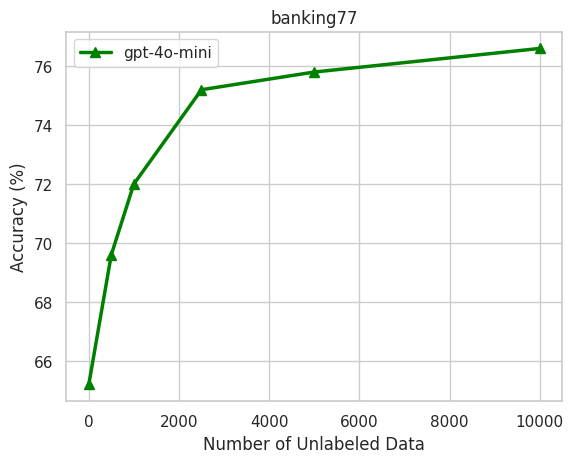

In [16]:
# save in a dataframe
results = pd.DataFrame({'num_unlabeled_data': num_unlabeled_data_list, 'best_results': best_results, 'best_ks': best_ks})
results.to_csv(f'results.csv', float_format='%.3f')

print(results)

# plot the results
plt.plot(results['num_unlabeled_data'], results['best_results'], marker='^', label=f'{llm}', alpha=1, lw=2.5, ms=7.5, color='green')

plt.xlabel('Number of Unlabeled Data')
plt.ylabel('Accuracy (%)')
plt.title(f'{dataset}')
plt.legend()
# save the plot
plt.savefig(f'results.pdf', bbox_inches='tight')
plt.show()